# Toy Example: Ridge Regression vs. SVM
<p></p>
    
<div style="text-align:justify">
    In this toy example we will compare two machine learning models: <em>Ridge Regression</em> and <em>C-SVM</em>. The data is generated <em>in silico</em> and is only used to illustrate how to use <em>Ridge Regression</em> and <em>C-SVM</em>.
</div>

## Problem Description of the Toy Example
<p></p>
    
<div style="text-align:justify">
A new cancer drug was developed for therapy. During the clinical trail the researchers releaized that the drug had a faster response for a certain subgroup of the patients, while it was less responsive in the others. In addition, the researchers recognized that the drug leads to severe side-effects the longer the patient is treated with the drug. The goal should be to reduce the side effects by treating only those patients that are predicted to have a fast response when taking the drug.
</div>
<br>
<div style="text-align:justify">
The researches believe that different genetic mutations in the genomes of the individual patients might play a role for the differences in response times.
</div>
<br>
<div style="text-align:justify">
    The researches contacted the <em>machine learning</em> lab to build a predictive model. The model should predict the individual response time of the drug based on the individual genetic backgrounds of a patient.
</div>
<br>
<div style="text-align:justify">
For this purpose, we get a dataset of 400 patients. For each patient a panel of 600 genetic mutations was measured. In addition, the researchers measured how many days it took until the drug showed a positive response.
</div>


## 1. Using Ridge Regression to predict the response time
<div style="text-align:justify">
    To predict the response time of the drug for new patients, we will train a <em>Ridge Regression</em> model. The target variable for this task is the response time in days. The features are the 600 genetic mutations measured for each of the 400 patients. To avoid overfitting we will use a nested-crossvalidation to determine the optimal hyperparamter.
</div>
### 1.1 Data Preprocessing

In [1]:
%matplotlib inline
import scipy as sp
import matplotlib
import pylab as pl
matplotlib.rcParams.update({'font.size': 15})

from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV,StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc

def visualized_variance_bias_tradeoff(hyperp, line_search, optimal_hyperp,classification=False):
    pl.figure(figsize=(18,7))
    if classification:
        factor=1
    else:
        factor=-1
    pl.plot(hyperp,line_search.cv_results_['mean_train_score']*factor,label="Training Error",color="#e67e22")
    pl.fill_between(hyperp,
                    line_search.cv_results_['mean_train_score']*factor-line_search.cv_results_['std_train_score'],
                    line_search.cv_results_['mean_train_score']*factor+line_search.cv_results_['std_train_score'],
                    alpha=0.3,color="#e67e22")
    pl.plot(hyperp,line_search.cv_results_['mean_test_score']*factor,label="Validation Error",color="#2980b9")
    pl.fill_between(hyperp,
                    line_search.cv_results_['mean_test_score']*factor-line_search.cv_results_['std_test_score'],
                    line_search.cv_results_['mean_test_score']*factor+line_search.cv_results_['std_test_score'],
                    alpha=0.3,color="#2980b9")
    pl.xscale("log")
    if classification:
        pl.ylabel("Accuracy")
    else:
        pl.ylabel("Mean Squared Error")
    pl.xlabel("Hyperparameter")
    pl.legend(frameon=True)
    pl.grid(True)
    pl.axvline(x=optimal_hyperp,color='r',linestyle="--")
    pl.title("Training- vs. Validation-Error (Optimal Hyperparameter = %.1e)"%optimal_hyperp);

random_state = 42

#Load Data
data = sp.loadtxt("data/X.txt")
binary_target = sp.loadtxt("data/y_binary.txt")
continuous_target = sp.loadtxt("data/y.txt")

#Summary of the Data
print("Orginal Data")
print("Number Patients:\t%d"%data.shape[0])
print("Number Features:\t%d"%data.shape[1])
print()

#Split Data into Training and Testing data
train_test_data = train_test_split(data,
                                   continuous_target,
                                   test_size=0.2,
                                   random_state=random_state)
training_data = train_test_data[0]
testing_data = train_test_data[1]
training_target = train_test_data[2]
testing_target = train_test_data[3]

print("Training Data")
print("Number Patients:\t%d"%training_data.shape[0])
print("Number Features:\t%d"%training_data.shape[1])
print()
print("Testing Data")
print("Number Patients:\t%d"%testing_data.shape[0])
print("Number Features:\t%d"%testing_data.shape[1])

Orginal Data
Number Patients:	400
Number Features:	600

Training Data
Number Patients:	320
Number Features:	600

Testing Data
Number Patients:	80
Number Features:	600


### 1.2 Train Ridge Regression on training data

The first step is to train the ridge regression model on the training data with a **5-fold cross-validation** with an **internal line-search** to find the **optimal hyperparameter $\alpha$**. We will plot the **training errors** against the **validation errors**, to illustrate the effect of different $\alpha$ values.

5-fold nested cross-validation
Mean-Squared-Error:		587.09 (-+ 53.45)



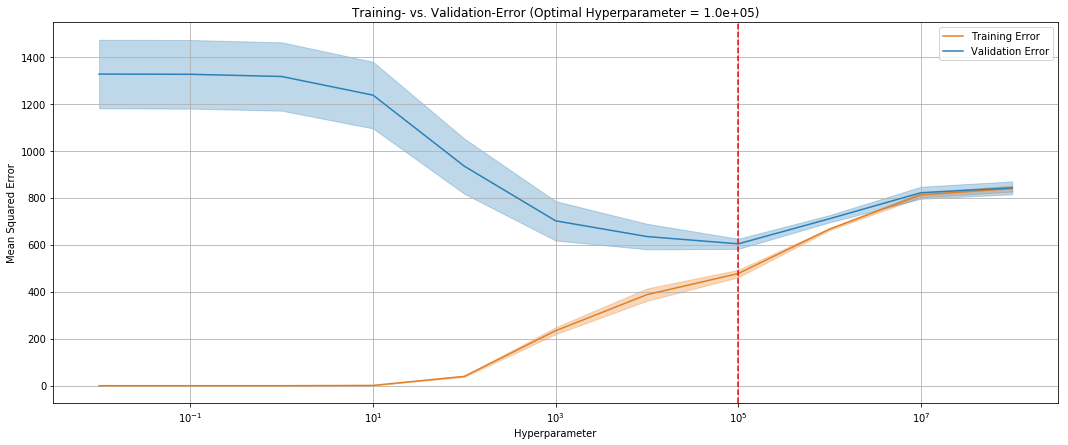

In [2]:
#Initialize different alpha values for the Ridge Regression model
alphas = sp.logspace(-2,8,11)
param_grid = dict(alpha=alphas)

#5-fold cross-validation (outer-loop)
outer_cv = KFold(n_splits=5,shuffle=True,random_state=random_state)

#Line-search to find the optimal alpha value (internal-loop)
#Model performance is measured with the negative mean squared error
line_search = GridSearchCV(Ridge(random_state=random_state,solver="cholesky"),
                           param_grid=param_grid,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

#Execute nested cross-validation and compute mean squared error
score = cross_val_score(line_search,X=training_data,y=training_target,cv=outer_cv,scoring="neg_mean_squared_error")

print("5-fold nested cross-validation")
print("Mean-Squared-Error:\t\t%.2f (-+ %.2f)"%(score.mean()*(-1),score.std()))
print()

#Estimate optimal alpha on the full training data
line_search.fit(training_data,training_target)
optimal_alpha = line_search.best_params_['alpha']

#Visualize training and validation error for different alphas
visualized_variance_bias_tradeoff(alphas, line_search, optimal_alpha)

### 1.3 Train Ridge Regression with optimal $\alpha$ and evaluate model in test data
Next we retrain the ridge regresssion model with the optimal $\alpha$ (from the last section). After re-training we will test the model on the not used test data to evaluate the model performance on unseen data.

In [3]:
#Train Ridge Regression on the full training data with optimal alpha
model = Ridge(alpha=optimal_alpha,solver="cholesky")
model.fit(training_data,training_target)

#Use trained model the predict new instances in test data
predictions = model.predict(testing_data)
print("Prediction results on test data")
print("MSE (test data, alpha=optimal):\t%.2f "%(mean_squared_error(testing_target,predictions)))
print("Optimal Alpha:\t\t\t%.2f"%optimal_alpha)
print()

Prediction results on test data
MSE (test data, alpha=optimal):	699.56 
Optimal Alpha:			100000.00




<div style="text-align:justify">
    Using 5-fold cross-validation on the training data leads to a mean squared error (MSE) of $MSE=587.09 \pm 53.54$. On the test data we get an error of $MSE=699.56$ ($\sim 26.5$ days). That indicates that the ridge regression model performs rather mediocre (even with hyperparameter optimization).
    One reason might be that the target variable (number of days until the drug shows a positive response) is insufficently described by the given features (genetic mutations).
</div>


## 2. Prediction of patients with slow and fast response times using a Support-Vector-Machine  

<div style="text-align:justify">
    Due to the rather bad results with the ridge regession model the machine learning lab returned to the researchers to discuss potential issues. The researches than mentioned that it might not be necessarily important to predict the exact number of days. It might be even better to only predict if a patient reacts fast or slowly on the drug. Based on some prior experiments the researchers observed, that most of the patients showed severe side-effects after 50 days of treatment. Thus we can binarise the data, such that all patients below 50 days are put into class 0 and all others into class 1. This leads to a classical classification problem for which a support vector machine could be used. 
</div>

### 2.1 Data Preprocessing

In [4]:
#Split data into training and testing splits, stratified by class-ratios
stratiefied_splitter = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in stratiefied_splitter.split(data,binary_target):
    training_data = data[train_index,:]
    training_target = binary_target[train_index]
    testing_data = data[test_index,:]
    testing_target = binary_target[test_index]

print("Training Data")
print("Number Patients:\t\t%d"%training_data.shape[0])
print("Number Features:\t\t%d"%training_data.shape[1])
print("Number Patients Class 0:\t%d"%(training_target==0).sum())
print("Number Patients Class 1:\t%d"%(training_target==1).sum())
print()
print("Testing Data")
print("Number Patients:\t\t%d"%testing_data.shape[0])
print("Number Features:\t\t%d"%testing_data.shape[1])
print("Number Patients Class 0:\t%d"%(testing_target==0).sum())
print("Number Patients Class 1:\t%d"%(testing_target==1).sum())

Training Data
Number Patients:		320
Number Features:		600
Number Patients Class 0:	160
Number Patients Class 1:	160

Testing Data
Number Patients:		80
Number Features:		600
Number Patients Class 0:	40
Number Patients Class 1:	40


### 2.2 Classification with a linear SVM

5-fold nested cross-validation on training data
Average(Accuracy):			0.80 (-+ 0.02)

Prediction with optimal C
Accuracy (Test data, C=Optimal):	0.82 
Optimal C:				1.00e-04



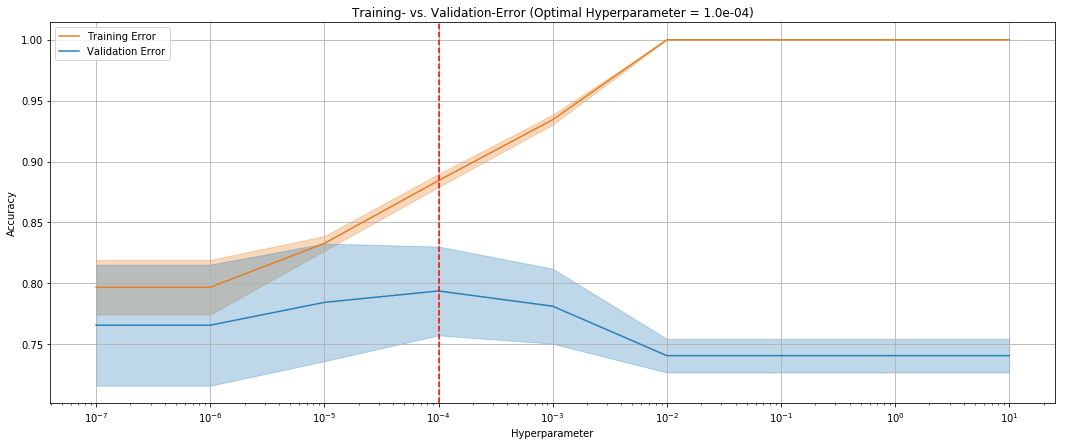

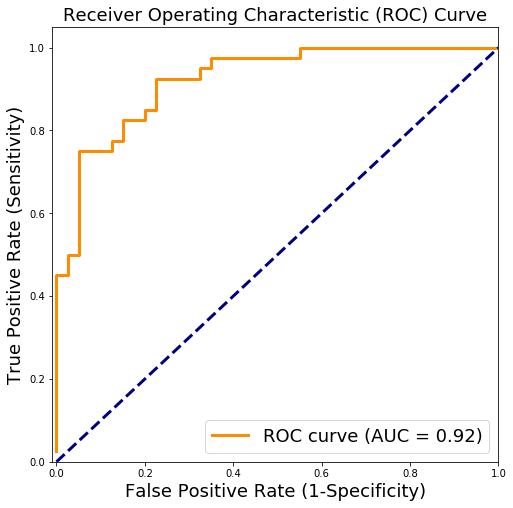

In [5]:
Cs = sp.logspace(-7, 1, 9)
param_grid = dict(C=Cs)

grid = GridSearchCV(SVC(kernel="linear",random_state=random_state),
                    param_grid=param_grid,
                    scoring="accuracy",
                    n_jobs=4,
                    return_train_score=True)
outer_cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=random_state)

#Perform 5 Fold cross-validation with internal line-search and report average Accuracy
score = cross_val_score(grid,X=training_data,y=training_target,cv=outer_cv,scoring="accuracy")

print("5-fold nested cross-validation on training data")
print("Average(Accuracy):\t\t\t%.2f (-+ %.2f)"%(score.mean(),score.std()))
print()
grid.fit(training_data,training_target)
optimal_C = grid.best_params_['C']

#Plot variance bias tradeoff
visualized_variance_bias_tradeoff(Cs, grid, optimal_C,classification=True)

#retrain model with optimal C and evaluate on test data
model = SVC(C=optimal_C,random_state=random_state,kernel="linear")
model.fit(training_data,training_target)
predictions = model.predict(testing_data)
print("Prediction with optimal C")
print("Accuracy (Test data, C=Optimal):\t%.2f "%(accuracy_score(testing_target,predictions)))
print("Optimal C:\t\t\t\t%.2e"%optimal_C)
print()

#Compute ROC FPR, TPR and AUC
fpr, tpr, _ = roc_curve(testing_target, model.decision_function(testing_data))
roc_auc = auc(fpr, tpr)

#Plot ROC Curve
pl.figure(figsize=(8,8))
pl.plot(fpr, tpr, color='darkorange',
         lw=3, label='ROC curve (AUC = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
pl.xlim([-0.01, 1.0])
pl.ylim([0.0, 1.05])
pl.xlabel('False Positive Rate (1-Specificity)',fontsize=18)
pl.ylabel('True Positive Rate (Sensitivity)',fontsize=18)
pl.title('Receiver Operating Characteristic (ROC) Curve',fontsize=18)
pl.legend(loc="lower right",fontsize=18)

### 2.3 Classification with SVM and RBF kernel


5-fold nested cross-validation on training data
Average(Accuracy):			0.86 (-+ 0.02)

Prediction with optimal C and Gamma
Accuracy (Test Data, C=Optimal):	0.93 
Optimal C:				1.00e+01
Optimal Gamma:				1.00e-05



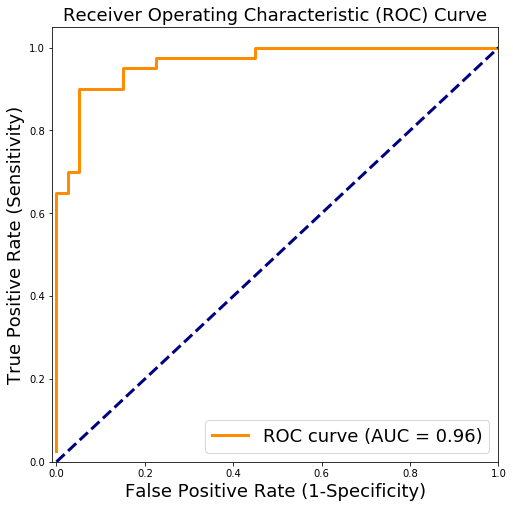

In [6]:
Cs = sp.logspace(-4, 4, 9)
gammas = sp.logspace(-7, 1, 9)
param_grid = dict(C=Cs,gamma=gammas)

grid = GridSearchCV(SVC(kernel="rbf",random_state=42),
                    param_grid=param_grid,
                    scoring="accuracy",
                    n_jobs=4,
                    return_train_score=True)

outer_cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=random_state)

#Perform 5 Fold cross-validation with internal line-search and report average Accuracy
score = cross_val_score(grid,X=training_data,y=training_target,cv=outer_cv,scoring="accuracy")

print("5-fold nested cross-validation on training data")
print("Average(Accuracy):\t\t\t%.2f (-+ %.2f)"%(score.mean(),score.std()))
print()

grid.fit(training_data,training_target)
optimal_C = grid.best_params_['C']
optimal_gamma = grid.best_params_['gamma']

#Retrain and test
model = SVC(C=optimal_C,gamma=optimal_gamma,random_state=42,kernel="rbf")
model.fit(training_data,training_target)
predictions = model.predict(testing_data)
print("Prediction with optimal C and Gamma")
print("Accuracy (Test Data, C=Optimal):\t%.2f "%(accuracy_score(testing_target,predictions)))
print("Optimal C:\t\t\t\t%.2e"%optimal_C)
print("Optimal Gamma:\t\t\t\t%.2e"%optimal_gamma)
print()

#Compute ROC FPR, TPR and AUC
fpr, tpr, _ = roc_curve(testing_target, model.decision_function(testing_data))
roc_auc = auc(fpr, tpr)

#Plot ROC Curve
pl.figure(figsize=(8,8))
pl.plot(fpr, tpr, color='darkorange',
         lw=3, label='ROC curve (AUC = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
pl.xlim([-0.01, 1.0])
pl.ylim([0.0, 1.05])
pl.xlabel('False Positive Rate (1-Specificity)',fontsize=18)
pl.ylabel('True Positive Rate (Sensitivity)',fontsize=18)
pl.title('Receiver Operating Characteristic (ROC) Curve',fontsize=18)
pl.legend(loc="lower right",fontsize=18)